# Adonmo's brightness control mechanism using daylight library

(*Written on June 1st, 2020*)

Adonmo operates more than 500 digital taxitop displays which roam around multiple cities like Hyderabad, Mumbai etc, at various times of the day. Since these screens are present on the road, at Adonmo, we constantly try our best to ensure that our displays are not causing any distraction to the ongoing trafic. We take several measure to do this - right from approving the design of creatives to controlling the brightness of the screens based on various parameters. Of this parameters, time of day remains one of the basic and major factors - through which a base brightness level of the screen is decided.

Originally this base brightness value was handpicked and set accordingly for each city. However, this approach has a few problems:
 - **⭐ Lack of Seasonality** - Every few months since sunsire/sunset times change because of change in season these values have to constant be updated.
 - **📍 Not scalable across Multiple cities/timezones** - Sun rises earlier in Hyderabad than in Mumbai - relying on timezone IST in not enough. Additionally, if we were to maintain for cities across the world, this solution does not scale.
 - **⚠️ Possibility of Human Error** - When brightness values are manually picked and maintained for city and season there is always a chance of human error to creep in.

To solve the above issues and come up with a more scalable solution, we built the ["daylight" library](https://github.com/adonmo/daylight). Using this we were able to come up with a brightness control mechanism that is not only season-independent, but also works anywhere in the world. Below code demonstrates how we achieved this.


## Initial setup
We load pandas, matplotlib and most importantly - [daylight](https://github.com/adonmo/daylight). And setup three example locations to showcase the end result.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import datetime
%matplotlib notebook
%pylab inline

tz = pytz.timezone("Asia/Kolkata")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import daylight

# Hyd
s_hyd = daylight.Sunclock(17.3850, 78.4867)

# Mumbai
s_mum = daylight.Sunclock(19.075999, 72.877393)

# Bangkok
s_bkk = daylight.Sunclock(13.736717, 100.523186)


# A small helper function which we will use later
def epoch(year, month, day, hour=0, minute=0, second=0, tz=pytz.UTC):
    return int(tz.localize(datetime.datetime(year, month, day, hour, minute, second)).timestamp())

## 🧠 Sanity test

Let's do a basic test to visualize and ensure that irradiance levels vary thoughout the day as expected. That is we should see higher values around noon, and it should drop sharply on either ends.

In [3]:
def plot_for_day(date, tz):
    df = pd.DataFrame([h * 60 + m for h, m in zip(range(24), range(60))], columns=['time_of_day'])
    df.set_index('time_of_day')
    df['irradiance'] = df['time_of_day'].apply(lambda t: s_hyd.irradiance(epoch(date.year, date.month, date.day, t//60, t%60, tz=tz)))
    df['irradiance'].plot()

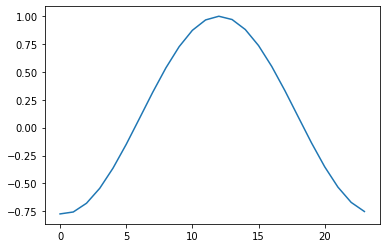

In [4]:
# Today
plot_for_day(datetime.date.today(), tz)

## ⭐ Season independence

daylight's irradience levels are computed using sun's elevation angle. This makes it to get reasonable irradiance values, independent of what season we are in. That is - we should expect higher irradiance values in summer and lower irradiance values in winter. Let's compare and contrast days from different seasons to ensure this.

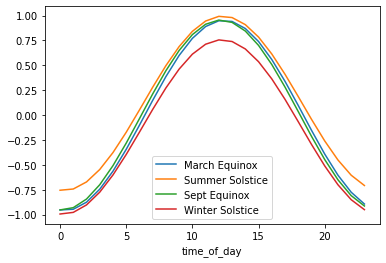

In [5]:
df = pd.DataFrame(range(24), columns=['time_of_day'])
df.set_index('time_of_day', inplace = True)
df['irradiance_eq1'] = df.index.map(lambda t: s_hyd.irradiance(epoch(2020, 3, 20, t, tz=tz)))
df['irradiance_ss'] = df.index.map(lambda t: s_hyd.irradiance(epoch(2020, 6, 21, t, tz=tz)))
df['irradiance_eq2'] = df.index.map(lambda t: s_hyd.irradiance(epoch(2020, 9, 23, t, tz=tz)))
df['irradiance_ws'] = df.index.map(lambda t: s_hyd.irradiance(epoch(2020, 12, 21, t, tz=tz)))
ax = df.plot()
ax.legend(['March Equinox', 'Summer Solstice', 'Sept Equinox', 'Winter Solstice']);

## 📍 Location independence

Using sun's elevation angle to compute irradiance - also make it location independent. This makes it to get reasonable irradiance values, independent of which city we are calculating it for. Let's compare and contrast days from different cities to ensure this.

In the below example you can see Bankok's irradiance values seems to rise earlier and fall earlier as expected - as sun rises in the east, and sets in the west.

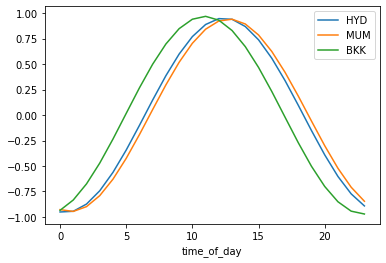

In [6]:
df = pd.DataFrame(range(24), columns=['time_of_day'])
df.set_index('time_of_day', inplace = True)
df['irradiance_eq1_hyd'] = df.index.map(lambda t: s_hyd.irradiance(epoch(2020, 3, 20, t, tz=tz)))
df['irradiance_eq1_mum'] = df.index.map(lambda t: s_mum.irradiance(epoch(2020, 3, 20, t, tz=tz)))
df['irradiance_eq1_bkk'] = df.index.map(lambda t: s_bkk.irradiance(epoch(2020, 3, 20, t, tz=tz)))
ax = df.plot()
ax.legend(['HYD', 'MUM', 'BKK']);

# 📈 Irradiance -> Brightness

The above pretty much covers the overview and benefits of the new brightness control mechanism. However, we do some minor adjustments over the irradiance values to convert them to suitable practical brightness values:

- **Normalization** - Irradiance values are between (-1, 1). Generally devices represent brightness values as percentages (0, 100).
- **Fine-Tuning** - From physical testing, we found a slightly sharper rise and fall is a bit more suitable for practical needs, specifically to lower down values in the early mornings and evenings - just to be on the safe side. We achieve this by using this formula - (norm_irradiance)^e where norm_irradiance is a value normalized between 0 and 1.
- **Min/max** - Say we want to restrict brightness values within (10, 60) within the original range of (0, 100) - we do the same, but instead we restrict on the lower end which is (0, 42).

Below two graphs showcase the final result.

<IPython.core.display.Javascript object>


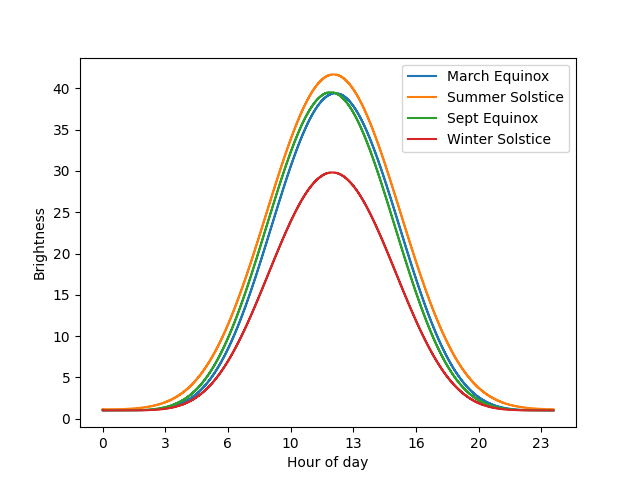

In [10]:
from matplotlib.ticker import FuncFormatter

df = pd.DataFrame([h * 60 + m * 1 for h in range(24) for m in range(60)], columns=['time_of_day'])
df.set_index('time_of_day', inplace = True)

def brightness(y, m , d, t):
    normalized = (s_hyd.irradiance(epoch(y, m, d, t//60, t%60, tz=tz)) + 1) / 2
    normalized = math.pow(normalized, math.e)
    min_b, max_b = 1, 42
    return min_b + (max_b - min_b) * normalized

def tick_format(x, pos):
    return int(x // 60)

df['brightness_eq1'] = df.index.map(lambda t: brightness(2020, 3, 20, t))
df['brightness_ss'] = df.index.map(lambda t: brightness(2020, 6, 21, t))
df['brightness_eq2'] = df.index.map(lambda t: brightness(2020, 9, 23, t))
df['brightness_ws'] = df.index.map(lambda t: brightness(2020, 12, 21, t))
%matplotlib notebook
ax = df.plot(drawstyle='steps')

ax.legend(['March Equinox', 'Summer Solstice', 'Sept Equinox', 'Winter Solstice'])
ax.xaxis.set_major_formatter(FuncFormatter(tick_format))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Brightness");

<IPython.core.display.Javascript object>


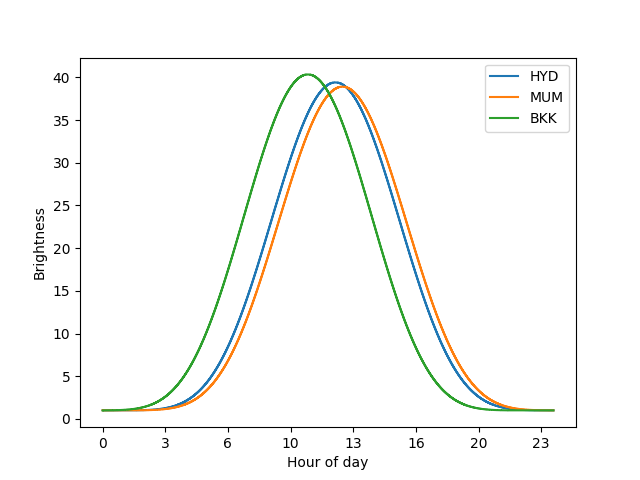

In [11]:
from matplotlib.ticker import FuncFormatter

df = pd.DataFrame([h * 60 + m * 1 for h in range(24) for m in range(60)], columns=['time_of_day'])
df.set_index('time_of_day', inplace = True)

def brightness(s, y, m , d, t):
    normalized = (s.irradiance(epoch(y, m, d, t//60, t%60, tz=tz)) + 1) / 2
    normalized = math.pow(normalized, math.e)
    min_b, max_b = 1, 42
    return min_b + (max_b - min_b) * normalized

def tick_format(x, pos):
    return int(x // 60)

df['brightness_eq1_hyd'] = df.index.map(lambda t: brightness(s_hyd, 2020, 3, 20, t))
df['brightness_eq1_mum'] = df.index.map(lambda t: brightness(s_mum, 2020, 3, 20, t))
df['brightness_eq1_bkk'] = df.index.map(lambda t: brightness(s_bkk, 2020, 3, 20, t))
%matplotlib notebook
ax = df.plot(drawstyle='steps')

ax.legend(['HYD', 'MUM', 'BKK'])
ax.xaxis.set_major_formatter(FuncFormatter(tick_format))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Brightness");

# 🆚 Before vs. After

Finally we do a little before v after comparision. Here `old_brightness` represents an example hardcoded brightness control mechanism. We see that new control mechanism looks much neater and smoother comparatively.

<IPython.core.display.Javascript object>


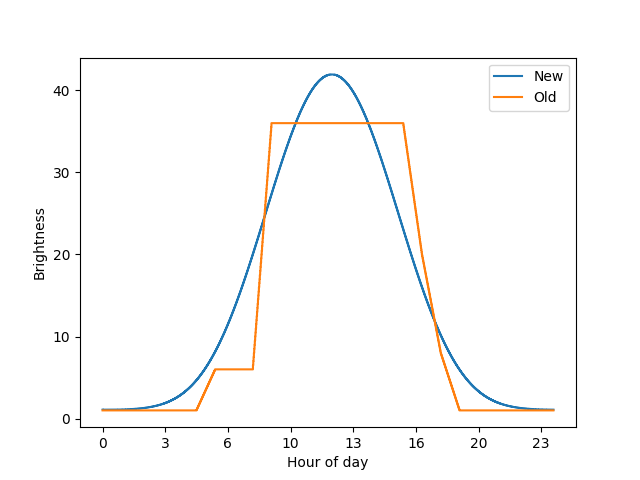

In [9]:
from matplotlib.ticker import FuncFormatter

df = pd.DataFrame([h * 60 + m * 1 for h in range(24) for m in range(60)], columns=['time_of_day'])
df.set_index('time_of_day', inplace = True)

def old_brightness(t):
    def f(h):
        if h < 6:
            return 1
        elif h < 9:
            return 6
        elif h < 17:
            return 36
        elif h < 18:
            return 20
        elif h < 19:
            return 8
        return 1
    # linear interpolation for the ending 30m
    h, m = t//60, t%60
    p, q = m / 60, (60 - m) / 60
    return q * f(h) + p * f(h+1)

def brightness(s, y, m , d, t):
    normalized = (s.irradiance(epoch(y, m, d, t//60, t%60, tz=tz)) + 1) / 2
    normalized = math.pow(normalized, math.e)
    min_b, max_b = 1, 42
    return min_b + (max_b - min_b) * normalized

def tick_format(x, pos):
    return int(x // 60)

df['brightness_eq1_new'] = df.index.map(lambda t: brightness(s_hyd, 2020, 5, 21, t))
df['brightness_eq1_old'] = df.index.map(lambda t: old_brightness(t))
%matplotlib notebook
ax = df.plot(drawstyle='steps')

ax.legend(['New', 'Old'])
ax.xaxis.set_major_formatter(FuncFormatter(tick_format))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Brightness");